# Exercise 10) Function Approximators in Control

After looking at function-approximator prediction we are now ready to investigate function-approximator control. This topic is still being researched and there are many interesting applications, but most of them are not yet used economically because experts in reinforcement learning are scarce. Control tasks are generally more complex than prediction tasks and we often need to apply domain-specific expert knowledge and very performant algorithms to succeed with function approximators.

As in the last exercise we will have a look at the MountainCar from OpenAI's `gym`.

Please make sure to have `sklearn` installed:

`pip install sklearn`

In [9]:
import numpy as np
import gym
import random
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')
from mpl_toolkits.mplot3d import Axes3D
from collections import deque
from sklearn.kernel_approximation import RBFSampler
import sklearn.pipeline
import sklearn.preprocessing

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

## 1) Artificial Neural Networks for Semi-Gradient SARSA Control

For the start, we will try to control the MountainCar in the same fashion that enabled us to predict the value function in the last exercise. You can refer to the last exercise to see how `Tensorflow` can be used here. Write a learning algorithm that utilizes the given ANN setup to control the MountainCar. Episodes will terminate automatically after $200$ timesteps if the finish line has not been reached. Since every timestep is rewarded with $r=-1$, the goal should be to reach the finish line as fast as possible. 

State space: $x = \begin{bmatrix}\text{position} \\ \text{velocity}
\end{bmatrix} \in 
\begin{bmatrix}[-1.2, 0.6] \\ [-0.07, 0.07]
\end{bmatrix}$

Feature vector: $\tilde{x} \in 
\begin{bmatrix}[-1, 1] \\ [-1, 1]
\end{bmatrix}$ (you may want to change or extend these features)

Input space: $u \in \{ 0 \text{ (left)}, 1 \text{ (idle)}, 2 \text{ (right)}\}$

We will give the same features as in the last exercise: simply MinMax-normalized states. Feel free to enhance this feature vector in order to improve the trainability of this algorithm.

As explained, control problems with the use of function approximators tend to be quite hard. If you have the feeling of wasting your time, please proceed to the next task before giving up this exercise.

![](https://media.giphy.com/media/xUPJPgq5NcxbKHrcXK/giphy.gif)

The following two cells will implement the `featurize` and the `plot_surface` function. The latter can be used to monitor the quality of the training.

In [1]:
def featurize(state):
    pos = state[0]
    pos_min = -1.2
    pos_max = +0.6
    
    vel = state[1]
    vel_min = -0.07
    vel_max = +0.07
    
    norm_pos = (pos - pos_min) / (pos_max - pos_min) * 2 - 1
    norm_vel = (vel - vel_min) / (vel_max - vel_min) * 2 - 1
    
    return np.array([[norm_pos, norm_vel]])

In [2]:
def plot_surface(model, input_dim, visited_states):
    resolution = 100
    pos_vec = np.linspace(-1.2, 0.6, resolution)
    vel_vec = np.linspace(-0.07, 0.07, resolution)

    pos_mat, vel_mat = np.meshgrid(pos_vec, vel_vec)
    state_tensor = np.zeros([resolution, resolution, input_dim])

    for pos_idx, pos in enumerate(tqdm(pos_vec)):
        for vel_idx, vel in enumerate(vel_vec):
            state_tensor[vel_idx, pos_idx] = featurize(np.array([pos, vel]))

    q_mat = model(state_tensor)
    q_maxes = np.reshape(np.max(q_mat, axis=2), (resolution, resolution))
    
    normalized_visited = np.zeros([len(visited_states[:, 0]), input_dim])
    for idx, (pos, vel) in enumerate(tqdm(zip(visited_states[:, 0], visited_states[:, 1]), total = len(visited_states[:, 0]))):
        normalized_visited[idx] = featurize(np.array([pos, vel]))
        
    visited_values = model(np.array([normalized_visited]))
    visited_values = np.max(visited_values, axis = 2)

    # Plot
    fig = plt.subplots()
    ax = plt.axes(projection='3d')
    ax.plot_surface(pos_mat, vel_mat, -q_maxes, cmap="viridis")
    ax.scatter(visited_states[:, 0], visited_states[:, 1], -visited_values-0.05, color="red")
    ax.set_xlabel('\n\nposition')
    ax.set_ylabel('\n\nvelocity')
    ax.set_zlabel(r'$-V_\mathrm{greedy}$', labelpad=12)
    ax.view_init(50, -135)
    plt.show()

Length: 178
Episode 0


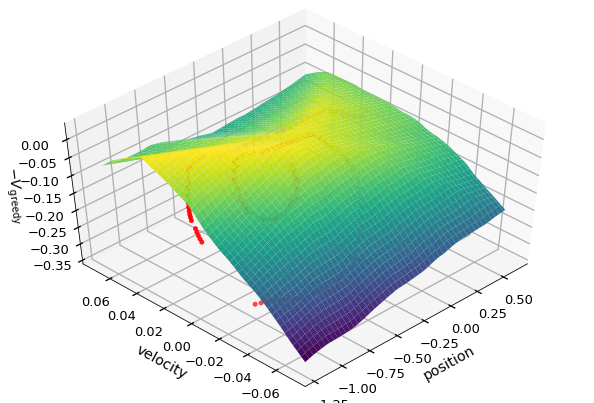

Length: 200
Episode 100


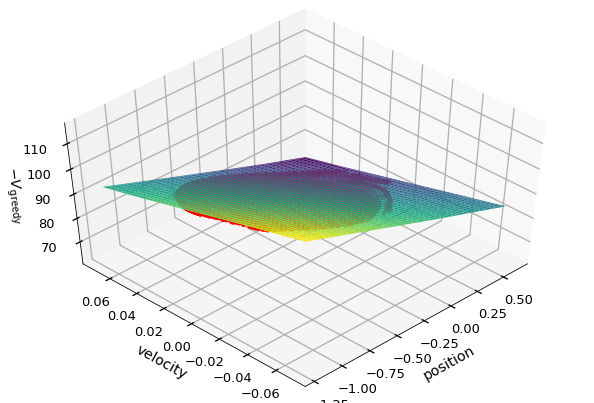

Length: 200
Episode 200


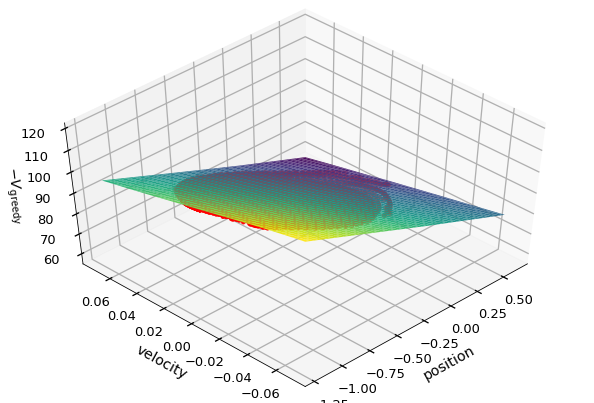

In [4]:
alpha = 0.0001
gamma = 1
epsilon = 0.15
nb_episodes = 300

env = gym.make('MountainCar-v0')

state = env.reset()
norm_state = featurize(state)
input_dim = len(norm_state[0])


# define ANN topology
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=input_dim))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='linear'))

opt = SGD(learning_rate=alpha)
mse = tf.keras.losses.MeanSquaredError()

visited_states = []

for j in tqdm(range(nb_episodes)):
    k = 0
    rewards = 0
    
    state = env.reset()
    norm_state = featurize(state)
    
    
    action_values = np.squeeze(model(norm_state).numpy())
    
    # Choose Initial Action greedy
    if epsilon < np.random.rand(1):
        action = np.argmax(action_values)
    else:
        action = random.choice(range(3))
    
    while True:
        #env.render()
        
        k += 1

        ### STEP        
        visited_states.append(state.tolist())
        next_state, reward, done, _ = env.step(action)            
        norm_next_state= featurize(next_state)
        rewards += rewards
        
        next_action_values = np.squeeze(model(norm_next_state).numpy())
        
        if epsilon < np.random.rand(1):
            next_action = np.argmax(next_action_values)
        else:
            next_action = random.choice(range(3))
            
        ### LEARN                       
        if not done:
            target = reward + gamma * next_action_values[next_action]
        else:
            target = np.array([[reward]])

        # calculate the loss (the prediciton error)
        with tf.GradientTape() as tape:
            action_values = model(norm_state)
            loss = mse(np.array([target]), action_values[0][action])

        # calculate and apply the gradients dMSE/dw
        gradients = tape.gradient(loss, model.trainable_variables)
        opt.apply_gradients(zip(gradients, model.trainable_variables))
        
        norm_state = norm_next_state
        state = next_state
        action = next_action
        
        if done:
            if j % 100 == 0:
                print(f"Length: {k}")
                print(f"Episode {j}")
                plot_surface(model, input_dim, np.array(visited_states))
            break            
        
    env.close()
    

Use the following cell to test the greedy-execution scenario.

In [122]:
env = gym.make('MountainCar-v0')
state = env.reset()

k = 0

while True:
    env.render()
    k += 1
    
    norm_state = featurize(state)
    action_values = np.squeeze(model(norm_state).numpy())
    action = np.argmax(action_values)
    state, reward, done, _ = env.step(action)
    
    if done:
        break

print(k)
env.close()

200


## Solution 1)

Since extrapolation/generalization is very dominant with simple features, the (action-)value of many unseen states is based on the seen reward of a few states around the initial position. This will tear down the action-value estimation within the whole state space, which negates any optimistic parameter initialization. Therefore, inherent exploration based on action-values that are initialized to high values as we have seen it in the first exercises (e.g. in the MonteCarlo Racetrack scenario) will not be performed here and exploration will be halted rather soon.

## 2) Feature Engineering in Function Approximation

As you may have seen, on-policy control is so much more complicated than prediction because some simple features as in task 1 will not always do the trick. A problem that can often be seen in cases like this originates from the generalization aspect of the ANN. Usually, generalization is an advantage, but we have to explore the state space sufficiently to enable its validity. In the MountainCar scenario, the state space can not be explored with simple means because reaching a specific state is always bound to preconditions. 

In order to overcome this generalization dilemma, a very different feature encoding can be employed. This can be done in the form of e.g. radial basis functions (RBFs), using RBF-feature 
$x_i = e^{-\frac{||x - c_\mathrm{i}||^2}{2 \sigma_\mathrm{i}^2}}$.

For more information, you can read up in the Sutton and Barto (page 221 ff.).

![](RBF.png)
(Source: Reinforcement Learning, Sutton&Barto, p.221)

With this encoding the feature vector will get very large, meaning that the dependency of the ANN output on single feature components will decrease. Contrary to just using the states as features, this will decrease the ANNs ability to extrapolate to unseen areas, because a very different set of features will be "active" within different regions of the state space. 

The following cell will prepare an RBF featurizer for the given state space. You should be able to use the same training algorithm as in task 1. (And if you happened to give up on task 1 before preparing a training algorithm, you now still have the chance to write one :P ).
Show the learning curves (mean and standard deviation) as function of steps per episode! Therefore, evaluate multiple independent learning runs to retrieve the information required for plotting.  

In [3]:
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

featurizer = sklearn.pipeline.FeatureUnion([
    ("rbf0", RBFSampler(gamma=5.0, n_components = 100)),
    ("rbf1", RBFSampler(gamma=2.0, n_components = 100)),
    ("rbf2", RBFSampler(gamma=1.0, n_components = 100)),
    ("rbf3", RBFSampler(gamma=0.5, n_components = 100)),
    ])
featurizer.fit(scaler.transform(observation_examples))


def featurize(state):
    try:
        scaled = scaler.transform([state])
    except:
        print(state)
    featurized = featurizer.transform(scaled)
    return featurized

Function to measure the performance using greedy execution.

In [4]:
def performance_measure(measure_len = 20, epsilon=0):
    k_vec = np.zeros(measure_len)
    
    for i in range(measure_len):
        
        k = 0
        state = env.reset()
        
        while True:
            # env.render()
            k += 1
            norm_state = featurize(state)
            action_values = np.squeeze(model(norm_state).numpy())
            
            if epsilon < np.random.rand(1):
                action = np.argmax(action_values)
            else:
                action = random.choice(range(3))
                    
            state, reward, done, _ = env.step(action)

            if done:
                k_vec[i] = k
                break
                
    return np.mean(k_vec), np.std(k_vec)

In [11]:
alpha = 0.0001
gamma = 1
epsilon = 0.15
nb_episodes = 100
nb_perf_meas = 20

env = gym.make('MountainCar-v0')

state = env.reset()
norm_state = featurize(state)
input_dim = len(norm_state[0])


performance_matrix = np.zeros((nb_episodes, nb_perf_meas))
best_performance = np.zeros((nb_perf_meas,2))

for m in tqdm(range(nb_perf_meas)):

    # define ANN topology
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_dim))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='linear'))

    opt = SGD(learning_rate=alpha)
    mse = tf.keras.losses.MeanSquaredError()

    visited_states = []




    for j in tqdm(range(nb_episodes)):
        k = 0
        rewards = 0

        state = env.reset()
        norm_state = featurize(state)


        action_values = np.squeeze(model(norm_state).numpy())

        # Choose Initial Action greedy
        if epsilon < np.random.rand(1):
            action = np.argmax(action_values)
        else:
            action = random.choice(range(3))

        while True:
            #env.render()

            k += 1

            ### STEP        
            visited_states.append(state.tolist())
            next_state, reward, done, _ = env.step(action)            
            norm_next_state= featurize(next_state)
            rewards += rewards

            next_action_values = np.squeeze(model(norm_next_state).numpy())

            if epsilon < np.random.rand(1):
                next_action = np.argmax(next_action_values)
            else:
                next_action = random.choice(range(3))

            ### LEARN                       
            if not done:
                target = reward + gamma * next_action_values[next_action]
            else:
                target = np.array([[reward]])

            # calculate the loss (the prediciton error)
            with tf.GradientTape() as tape:
                action_values = model(norm_state)
                loss = mse(np.array([target]), action_values[0][action])

            # calculate and apply the gradients dMSE/dw
            gradients = tape.gradient(loss, model.trainable_variables)
            opt.apply_gradients(zip(gradients, model.trainable_variables))

            norm_state = norm_next_state
            state = next_state
            action = next_action

            if done:
                #performance_mean, performance_std = performance_measure()
                performance_matrix[j,m] = k 
                if j % 100 == 0:
                    print(f"Length: {k}")
                    print(f"Episode {j}")
                    #plot_surface(model, input_dim, np.array(visited_states))
                break  
                
    best_performance[m][0], _ = performance_measure(epsilon=0)
    best_performance[m][1], _ = performance_measure(epsilon=0.15)
        
    env.close()
    

Length: 200
Episode 0




Show the performance over the episodes of the 20 runs (average +- standard deviadtion):

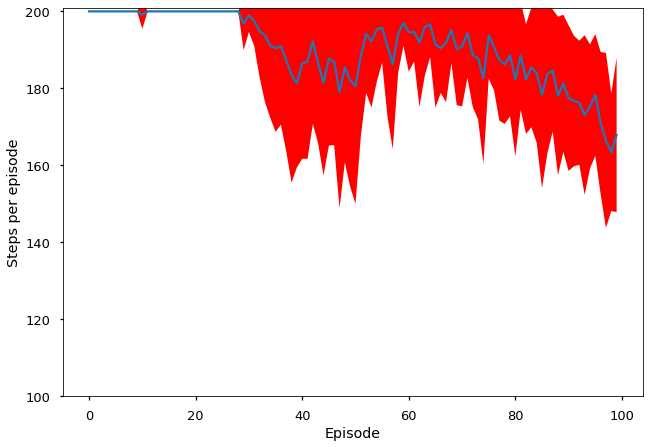

In [202]:
fig, axs = plt.subplots()
epochs = list(range(100))
perf_mean = (np.mean(performance_matrix, axis = 1))
perf_std = np.std(performance_matrix, axis = 1)


axs.plot(epochs, perf_mean)
axs.fill_between(epochs, perf_mean-perf_std, perf_mean+perf_std, facecolor='r')
axs.set_ylim([100,201])
plt.ylabel('Steps per episode')
plt.xlabel('Episode')
plt.show()

The following plots show boxplots of the greedy and epsilon-greedy ($\epsilon = 0.15$) execution of the 20 trained agents after 100 episodes:

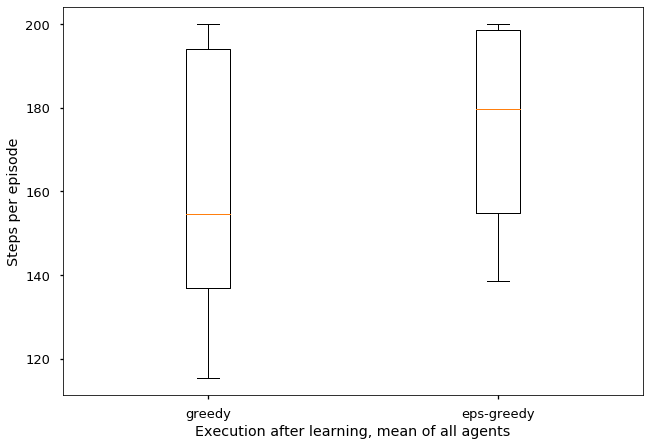

In [204]:
plt.boxplot( best_performance)
plt.ylabel('Steps per episode')
plt.xlabel('Execution after learning, mean of all agents')
plt.xticks([1, 2], ['greedy', 'eps-greedy'])
plt.show()


In [13]:
env.close()

env = gym.make('MountainCar-v0')
state = env.reset()

k = 0

while True:
    env.render()
    k += 1
    norm_state = featurize(state)
    action_values = np.squeeze(model(norm_state).numpy())
    action = np.argmax(action_values)
    state, reward, done, _ = env.step(action)
    
    if done:
        break

print(k)
env.close()

140


In [217]:

env.close()

## 3)  Feature Engineering in Linear Approximation with Online LSPI

As we have seen, the RBF feature engineering allows for good trainability of the ANN. Maybe, a similar result can even be achieved with the use of a linear function approximator if this feature encoding is reused. 

As we cannot encode the action itself with the same RBF method, we still needed to apply a change to the `featurize` function, such that the estimate can take the action properly into account. Please investigate the new `featurize` function and try to understand the motivation behind it.

Write an RLS-SARSA algorithm to train a linear function approximator that estimates the action value and enables on-policy control. 
Show the learning curves (mean and standard deviation) as function of steps per episode. Therefore, evaluate multiple independent learning runs to retrieve the information required for plotting.
Compare the two algorithms! 


In [10]:
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

featurizer = sklearn.pipeline.FeatureUnion([
    ("rbf0", RBFSampler(gamma=5.0, n_components = 100)),
    ("rbf1", RBFSampler(gamma=2.0, n_components = 100)),
    ("rbf2", RBFSampler(gamma=1.0, n_components = 100)),
    ("rbf3", RBFSampler(gamma=0.5, n_components = 100)),
    ])
featurizer.fit(scaler.transform(observation_examples))


def featurize(state, action):
    action_vec = np.zeros([3, 1])
    action_vec[action] = 1
    
    win = 0
    if state[0] > 0.5:
        win = 1
    
    try:
        scaled = scaler.transform([state])
    except:
        print(state)
    featurized = featurizer.transform(scaled)
    featurized = np.reshape(featurized, (-1, 1)) # make column vector
    
    featurized = np.append(featurized, np.array([[1]]), axis = 0)
    
    featurized_vec = np.array([])
    featurized_vec = np.expand_dims(featurized_vec, axis=-1)
    for a in action_vec:
        if a == 1:
            featurized_vec = np.append(featurized_vec, featurized, axis = 0)
        elif a == 0:
            featurized_vec = np.append(featurized_vec, np.zeros([len(featurized), 1]), axis = 0)        
    
    return featurized_vec * (1 - win) # append the action to the column vector


def policy(state, w, n, epsilon):
    feat_states = np.zeros([len(w), n, 1])
    q_value = np.zeros([n])

    for i in range(n):    
        feat_state = featurize(state, i)
        feat_states[:, i] = feat_state
        q_value[i] = np.transpose(feat_state) @ w
            
    if epsilon < np.random.rand(1):
        action = np.argmax(q_value)
    else:
        action = random.choice(range(n))
        
    return feat_states[:, action], action

In [11]:
def plot_surface_LSPI(w, input_dim):
    resolution = 100
    pos_vec = np.linspace(-1.2, 0.6, resolution)
    vel_vec = np.linspace(-0.07, 0.07, resolution)

    pos_mat, vel_mat = np.meshgrid(pos_vec, vel_vec)
    value_tensor = np.zeros([resolution, resolution])

    for pos_idx, pos in enumerate(tqdm(pos_vec)):
        for vel_idx, vel in enumerate(vel_vec):
            feat_state, _ =  policy(np.array([pos, vel]), w, env.action_space.n, 0)
            value_tensor[vel_idx, pos_idx] = np.transpose(feat_state) @ w

    # Plot
    fig = plt.subplots()
    ax = plt.axes(projection='3d')
    ax.plot_surface(pos_mat, vel_mat, -value_tensor, cmap="viridis")
    ax.set_xlabel('\n\nposition')
    ax.set_ylabel('\n\nvelocity')
    ax.set_zlabel(r'$-V_\mathrm{greedy}$', labelpad=12)
    ax.view_init(50, -135)
    plt.show()

In [12]:
def performance_measure(measure_len = 20, epsilon = 0):
    k_vec = np.zeros(measure_len)
    
    for i in range(measure_len):
        
        state = env.reset()

        
        k = 0
        
        while True:
            #env.render()
            k += 1

            _, action = policy(state, w_policy, env.action_space.n, epsilon)
            state, reward, done, _ = env.step(action)

            if done:
                k_vec[i] = k
                break

    return np.mean(k_vec), np.std(k_vec)

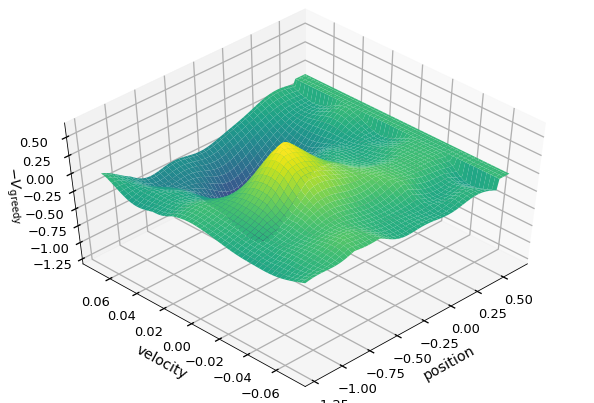

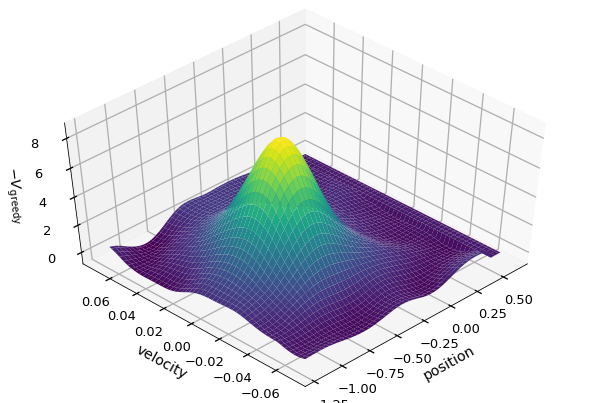

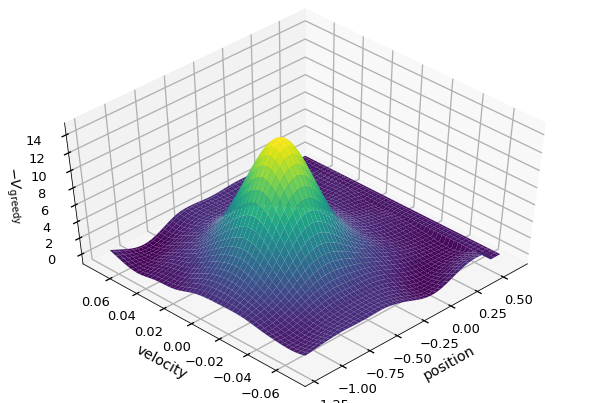

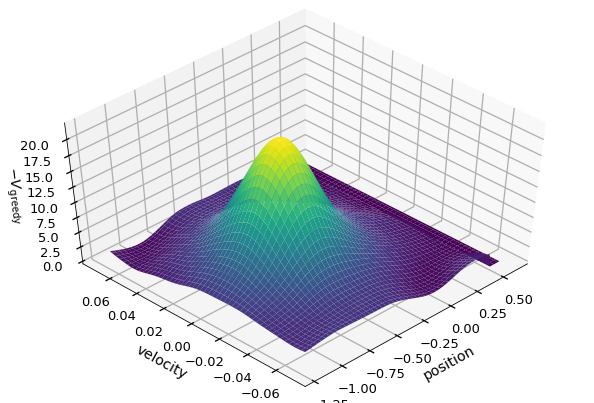

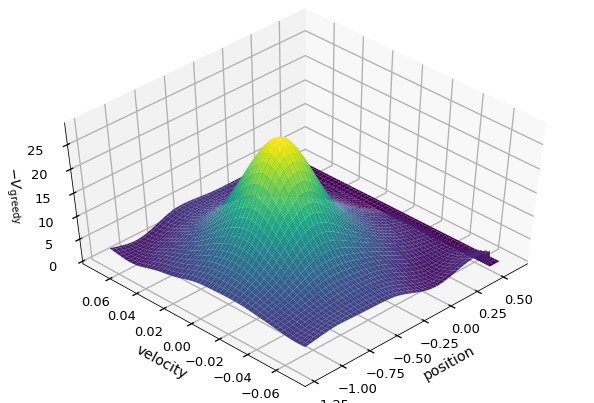

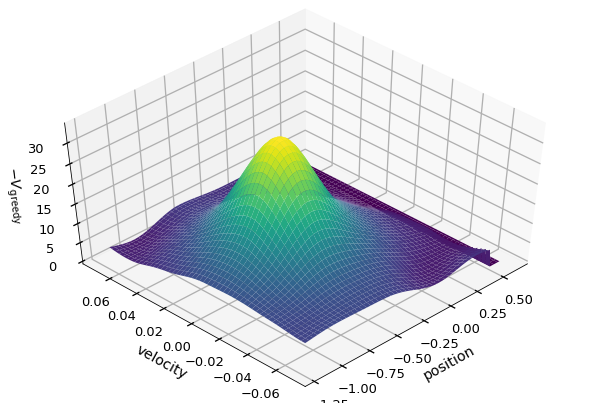

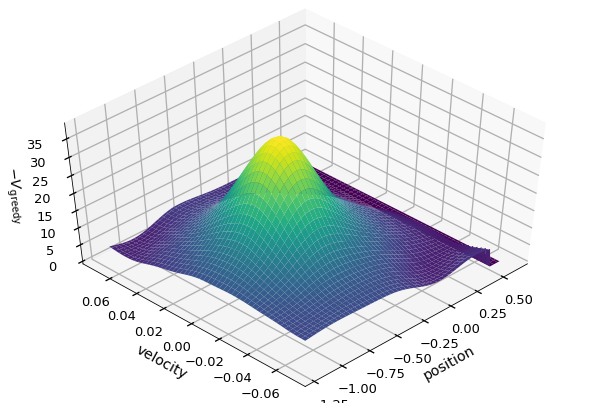

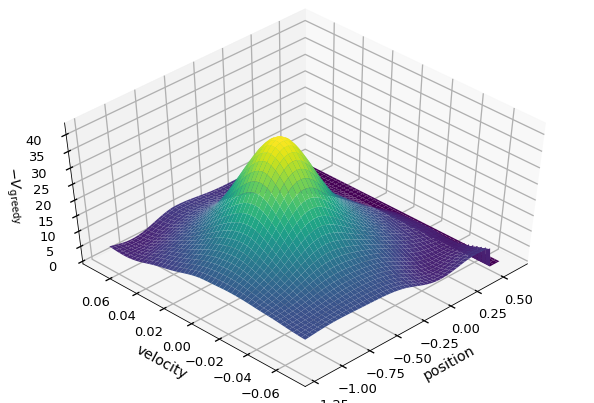

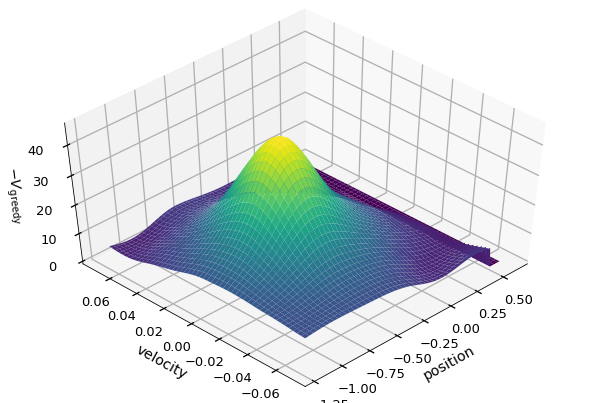

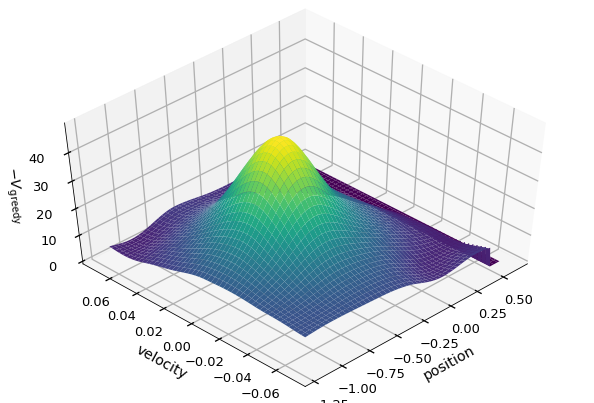

In [17]:
gamma = 1
# try lambda < 1, what do you see?
_lambda = 1 # we call it like that because lambda is a defined command in python
nb_episodes = 100
epsilon = 0.15
k_w = 10
nb_perf_meas = 20

env = gym.make('MountainCar-v0')
state = env.reset()
feat_state = featurize(state, 0)
feat_dims = len(feat_state)

performance_matrix_ = np.zeros((nb_episodes, nb_perf_meas))
best_performance = np.zeros((nb_perf_meas,2))

for m in tqdm(range(nb_perf_meas)):
    k = 0
    P = np.eye(feat_dims)
    w = np.zeros(feat_dims)
    w = np.expand_dims(w, axis=-1)

    w_policy = np.copy(w)




    for j in tqdm(range(nb_episodes)):
        
        length = 0

        state = env.reset()
        feat_state, action = policy(state, w, env.action_space.n, epsilon)

        while True:
            #env.render()

            next_state, reward, done, _ = env.step(action)
            feat_next_state, next_action = policy(next_state, w_policy, env.action_space.n, epsilon)


            # the RLS-TD update
            y = reward   
            xi = feat_state - gamma * feat_next_state
            c = (P @ xi) / (_lambda + np.squeeze(np.transpose(xi) @ P @ xi))
            w += c * np.squeeze(y - np.transpose(xi) @ w)
            P = (np.eye(feat_dims) - c @ np.transpose(xi)) @ P / _lambda

            if k % k_w == 0:
                w_policy = w

            # time propagation
            feat_state = feat_next_state
            state = next_state
            action = next_action

            k += 1
            length += 1

            if done:
                performance_matrix_[j,m] = length
                #print(f"Episode: {j}, Length {length}")
                if j % 10 == 0:
                    plot_surface_LSPI(w, feat_dims)
                break
                
    best_performance[m][0], _ = performance_measure(epsilon=0)
    best_performance[m][1], _ = performance_measure(epsilon=0.15)
        
    env.close()

In [23]:
env.close()
env = gym.make('MountainCar-v0')
state = env.reset()

k = 0

while True:
    env.render()
    k += 1
    
    _, action = policy(state, w_policy, env.action_space.n, 0)
    state, reward, done, _ = env.step(action)
    
    if done:
        break

print(k)
env.close()

89


Show the performance over the episodes of the 20 runs (average +- standard deviadtion):

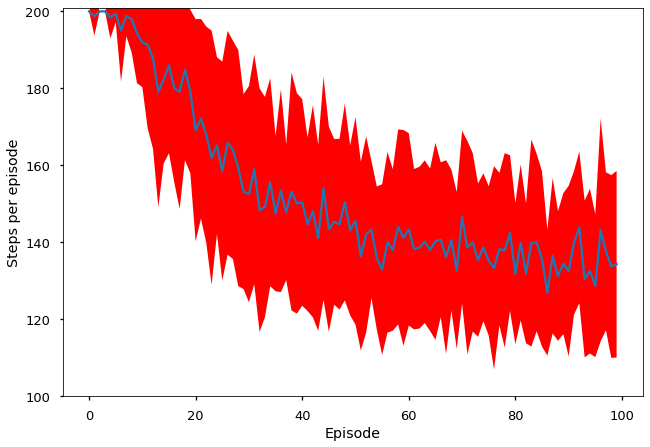

In [97]:
fig, axs = plt.subplots()
epochs = list(range(100))
perf_mean = (np.mean(performance_matrix_, axis = 1))
perf_std = np.std(performance_matrix_, axis = 1)


axs.plot(epochs, perf_mean)
axs.fill_between(epochs, perf_mean-perf_std, perf_mean+perf_std, facecolor='r')
axs.set_ylim([100,201])
plt.ylabel('Steps per episode')
plt.xlabel('Episode')
plt.show()

The following plots show boxplots of the greedy and epsilon-greedy ($\epsilon = 0.15$) execution of the 20 trained agents after 100 episodes:

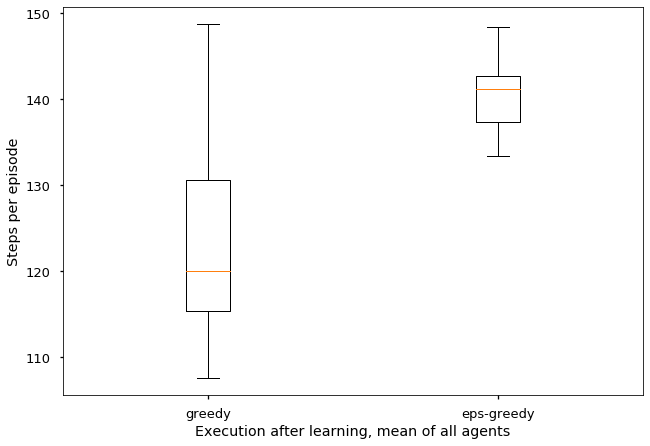

In [13]:
plt.boxplot( best_performance)
plt.ylabel('Steps per episode')
plt.xlabel('Execution after learning, mean of all agents')
plt.xticks([1, 2], ['greedy', 'eps-greedy'])
plt.show()


## 3) Solution

The use of an appropriate RBF feature engineering enables even a linear agent to solve the MountainCar environment. Since the policy is changing over time, it would be useful to set the $\lambda$-parameter lower than one. However, this can lead to numeric instability, so this degree of freedom has to be tuned with caution. With $\lambda=1$, all observations are weighted equally, which does not accurately describe the behavior of our changing policy. Nonetheless, the resulting estimator is able to perform acceptable on-policy control. With a rising number of training episodes, even the $\lambda=1$ training will converge to the correct action-value eventually (but we do not know how many episodes this may need).